In [2]:
import os
import sys
sys.path.append('../')

from helpers import helper
from dataloaders import dataloader
from networks import Unet
import config

import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

device = config.get_device()
trainset, train_dl = dataloader.getData('../../datasets/train.csv', batch_size=4, transform=config.transform, num_workers=config.num_workers)
testset, test_dl = dataloader.getData('../../datasets/test.csv', batch_size=4, transform=config.transform, num_workers=config.num_workers)

Using device: mps


Load model from ../models/unet_default.pth
Model saved to ../models/unet_default.pth
Input shape: torch.Size([4, 3, 256, 256])
Output shape torch.Size([4, 2, 256, 256])
loss: 531.802490234375


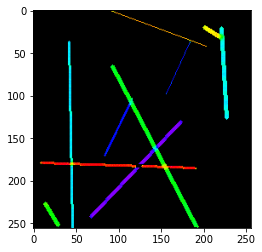

In [3]:
network = Unet.get_model()
network.save()

def test(decoder, dataloader):
    decoder.to(device)
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        print("Input shape:", images.shape)
        outputs = decoder(images)

        helper.plot_tensor_output(outputs[0])
        print("Output shape", outputs.shape)
        break

    loss = nn.MSELoss(reduction='sum')(outputs, labels)
    loss.backward()
    print(f'loss: {loss.item()}')
    
test(network, train_dl)

In [4]:
def train_one_epoch(network, train_dl, criterion, optimizer, scaler, device):
    network.train()
    train_loss = 0.0
    for images, labels in tqdm(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = network(images)
            loss = criterion(output, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss
        del output
        del loss
    # Decay LR by a factor of 0.1 every 2 epochs
    # exp_lr_scheduler.step()
    network.save()
    return train_loss/len(train_dl)

def test(network, val_dl, criterion, device):
    network.eval()
    val_loss = 0.0
    for images, labels in tqdm(val_dl):
        images = images.to(device)
        labels = labels.to(device)
        output = network(images)
        loss = criterion(output, labels)
        val_loss += loss
        del output
        del loss
    return val_loss/len(val_dl)

Train_loss = []
Test_loss = []

def train(network, train_dl, test_dl, device, epochs, lr=0.001):
    network.to(device)
    network.train()
    criterion = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(network.parameters(), lr)
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(50):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        train_loss = train_one_epoch(network, train_dl, criterion, optimizer, scaler, device)

        Train_loss.append(train_loss)
        with torch.no_grad():
            test_loss = test(network, test_dl, criterion, device)
        Test_loss.append(test_loss)
        print('Train Loss: {:.4f}; Test Loss: {:.4f}'.format(train_loss, test_loss))
        network.save()

train(network, train_dl, test_dl, device, 50, lr=0.001)

/Users/terry/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Epoch 1/50


  0%|          | 0/2500 [00:00<?, ?it/s]/Users/terry/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
  2%|▏         | 49/2500 [00:17<08:04,  5.06it/s] 